In [3]:
import os
import glob
from pathlib import Path
import polars as pl
import re
import gzip
import sys
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from lxml import etree, objectify
from rapidfuzz import fuzz
from spacy import displacy

import infineac.file_loader as file_loader
import infineac.helper as helper
import infineac.process_event as process_event
import infineac.topic_extractor as topic_extractor
import infineac.process_text as process_text

%load_ext autoreload
%autoreload 2

PATH_DIR = "../data/transcripts/"
random.seed(111)

c:\Users\fgabelbe\AppData\Local\miniconda3\envs\infineac\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\fgabelbe\AppData\Local\miniconda3\envs\infineac\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\fgabelbe\AppData\Local\miniconda3\envs\

## Load NLP model

In [1]:
import spacy_stanza
nlp_stanza = spacy_stanza.load_pipeline("en", processors="tokenize, lemma")
nlp_stanza.add_pipe('sentencizer')

c:\Users\fgabelbe\AppData\Local\miniconda3\envs\infineac\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-14 07:47:21 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-09-14 07:47:26 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| lemma     | combined |

2023-09-14 07:47:26 WARNING: GPU requested, but is not available!
2023-09-14 07:47:26 INFO: Using device: cpu
2023-09-14 07:47:26 INFO: Loading: tokenize
2023-09-14 07:47:26 INFO: Loading: lemma
2023-09-14 07:47:26 INFO: Done loading processors!


## Load Files

Load all xml files from the given directory and return a list of corresponding events.

In [5]:
# files = [Path("../data/transcripts/2022/15203138_T.xml")]
files = list(Path(PATH_DIR).rglob("*.xml"))
events = file_loader.load_files_from_xml(files)

Files: 100%|██████████| 189501/189501 [1:58:12<00:00, 26.72it/s]  


Check if all positions are valid

In [6]:
process_event.test_positions(events)

## Filter data

Filter out all events that are not in the given time range and do not include the given keywords.

In [12]:
events_filt_all = process_event.filter_events(events, year = 2019, keywords = {"russia":1, "ukraine":1}, modifier_words=[])
events_filt = process_event.filter_events(events, year = 2019, keywords = {"russia":1, "ukraine":1})
len(events_filt)

Filtering events


Events: 100%|██████████| 189501/189501 [01:12<00:00, 2611.10it/s]


Filtering events


Events: 100%|██████████| 189501/189501 [17:14<00:00, 183.23it/s] 


19909

In [11]:
helper.save_data(events, "data/events", compression="lz4")

In [13]:
helper.save_data(events_filt, "data/events_filt", compression="lz4")

List all events, that are filtered out due to modifier words preceding the keywords.

In [14]:
events_filtered_filter_words = []
ids_filtered_events = []
for i, event in enumerate(events_filt):
    ids_filtered_events.append(event['id'])
for event in events_filt_all:
    if event['id'] not in ids_filtered_events:
        events_filtered_filter_words.append(event)
print(len(events_filtered_filter_words))
process_event.extract_passages_from_events(events_filtered_filter_words, keywords=["russia", "ukraine"], modifier_words=[], nlp_model=nlp_stanza)

16
Extracting passages from events


Events: 100%|██████████| 16/16 [00:01<00:00, 13.69it/s]


[[[[['However, in June, year-over-year volume growth in all countries, except Russia, driven by strong demand recovery and share gains in key countries, resulted in year-over-year net sales growth and positive EBIT in the month.']]],
  []],
 [[[['As for automotive glass, in addition to depreciation of euro, demand declines in areas except Russia.']]],
  []],
 [[[['Napo EU, which will be a private company, will have an exclusive license to crofelemer, our novel, proprietary drug for the indications of inflammatory diarrhea and the current approved indication of crofelemer, Mytesi in the United States HIV-related diarrhea, and this is the exclusive license in Europe, excluding Russia.']]],
  []],
 [[[['Napo EU is currently a wholly-owned European subsidiary of Napo Pharmaceuticals, Inc. in Italy with an exclusive European, excluding Russia, license to crofelemer technology from Jaguar.'],
    ["Napo Pharma's wholly-owned subsidiary, Napo EU, has executed a license agreement with Jaguar g

## Exploration

In [15]:
file = [event['file'] for event in events_filt]
id = [event['id'] for event in events_filt]
year_upload = [event['year_upload'] for event in events_filt]
company = [event['company_name'] for event in events_filt]
ticker = [event['company_ticker'] for event in events_filt]
ticker_new = [re.sub('\\..*', '', t) for t in ticker]
dates = [event['date'] for event in events_filt if "date" in event.keys()]
numeric_values = mdates.date2num(dates)

russia_and_sanction = [process_text.get_russia_and_sanction(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
election = [process_text.get_elections(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
russia_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('russia') for event in events_filt]
sanction_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('sanction') for event in events_filt]

Create a DataFrame with the following columns:

In [16]:
df = pd.DataFrame({'file': file,
                   'year_upload': year_upload,
                   'company': company,
                   'ticker':ticker,
                   'ticker_new': ticker_new,
                   'date': dates,
                   'dates_num' : numeric_values,
                   'russia': russia_and_sanction,
                   'russia_count': russia_count,
                   'sanction_count': sanction_count,
                   'election': election})

Count the number of occasions where the word "russia" (and "sanction") appears in the earnings call.

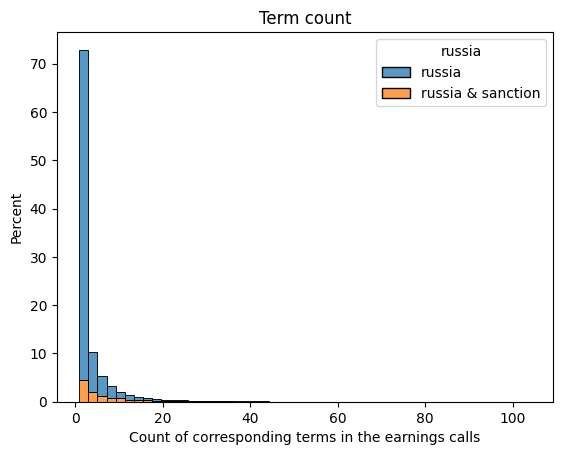

In [17]:
sns.histplot(df[df['russia_count']>=1], x='russia_count', hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
plt.xlabel('Count of corresponding terms in the earnings calls')
plt.ylabel('Percent')
plt.title('Term count')
plt.show()

Average mentions of "russia" per earnings call.

In [18]:
np.array(russia_count).mean()

2.8327389622783667

Average mentions of "russia" per earnings call if "russia" is mentioned at
least once.

In [19]:
np.array([el for el in russia_count if el > 0]).mean()

3.6488742236024843

Average mentions of "sanction" per earnings call.

In [20]:
np.array([el for el in sanction_count if el > 0]).mean()

2.442906574394464

Event distribution over time highlighting the different categories.

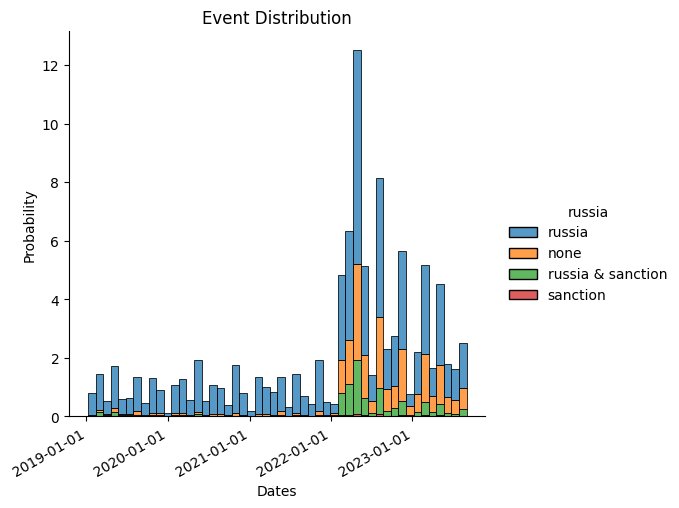

In [21]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Probability')
plt.title('Event Distribution')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

Event proportion over time highlighting the different categories.

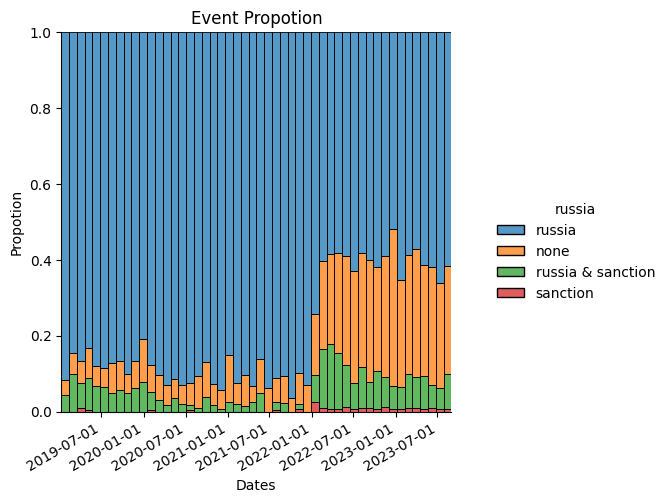

In [22]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="proportion", common_norm=True, multiple="fill")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Propotion')
plt.title('Event Propotion')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

## Preprocess and extract corpus

In [67]:
events_filt = helper.load_data("data/events_filt.lz4")

Create different types of corpora:
1. Corpus with a window of 1 sentence and not joining adjacent sentences.
2. Corpus with a window of 1 sentence and joining adjacent sentences.
3. Corpus with a window of 3 sentences and joining adjacent sentences.
4. Corpus with a window of 5 sentences and joining adjacent sentences.
5. Corpus with a window that includes the whole paragraph from the keywords on.

In [23]:
corpus_window_0_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=False,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_0_df.head()

Extracting passages from events


Events: 100%|██████████| 19909/19909 [40:57<00:00,  8.10it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 70658/70658 [22:04<00:00, 53.34it/s] 


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""And in Decembe…","""december board…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,0,"""Yes, about Rus…","""yes""",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,1,"""And it goes to…","""go germany cru…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,2,"""The Russian au…","""authority talk…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,3,"""So it is -- in…","""germany access…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""


In [26]:
corpus_window_0_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_0_join_df.head()

Extracting passages from events


Events: 100%|██████████| 19909/19909 [40:07<00:00,  8.27it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 62081/62081 [20:49<00:00, 49.70it/s]  


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""And in Decembe…","""december board…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,0,"""Yes, about Rus…","""yes""",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,1,"""And it goes to…","""go germany cru…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,2,"""The Russian au…","""authority talk…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,3,"""So it is -- in…","""germany access…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""


In [27]:
corpus_window_3_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,2],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_3_join_df.head()

Extracting passages from events


Events: 100%|██████████| 19909/19909 [40:06<00:00,  8.27it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 58090/58090 [25:39<00:00, 37.73it/s]  


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""And in Decembe…","""december board…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,0,"""Yes, about Rus…","""yes pipe druzh…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,1,0,"""And I had the …","""opportunity mi…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
1,0,0,0,0,"""This year, we …","""part book line…",11055903,2019,2019-02-06 07:00:00,"""Orkla ASA"""
1,1,0,0,0,"""And the sum of…","""sum income exp…",11055903,2019,2019-02-06 07:00:00,"""Orkla ASA"""


In [28]:
corpus_window_5_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,4],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_5_join_df.head()

Extracting passages from events


Events: 100%|██████████| 19909/19909 [40:00<00:00,  8.29it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 57086/57086 [26:53<00:00, 35.38it/s]  


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""And in Decembe…","""december board…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,0,"""Yes, about Rus…","""yes pipe druzh…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,1,0,"""And I had the …","""opportunity mi…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
1,0,0,0,0,"""This year, we …","""part book line…",11055903,2019,2019-02-06 07:00:00,"""Orkla ASA"""
1,1,0,0,0,"""We entered int…","""enter sale agr…",11055903,2019,2019-02-06 07:00:00,"""Orkla ASA"""


In [29]:
corpus_window_whole_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,-1],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_whole_join_df.head()

Extracting passages from events


Events: 100%|██████████| 19909/19909 [39:56<00:00,  8.31it/s]  


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 57114/57114 [32:07<00:00, 29.63it/s]  


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""And in Decembe…","""december board…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,0,0,"""Yes, about Rus…","""yes pipe druzh…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
0,1,0,1,0,"""And I had the …","""opportunity mi…",10603777,2019,2019-05-29 08:00:00,"""Total SA"""
1,0,0,0,0,"""This year, we …","""part book line…",11055903,2019,2019-02-06 07:00:00,"""Orkla ASA"""
1,1,0,0,0,"""We entered int…","""enter sale agr…",11055903,2019,2019-02-06 07:00:00,"""Orkla ASA"""


Save and load data

In [31]:
helper.save_data(corpus_window_0_df, "data/corpus_window_0_df_no_answer", compression="lz4")
helper.save_data(corpus_window_0_join_df, "data/corpus_window_0_join_df_no_answer", compression="lz4")
helper.save_data(corpus_window_3_join_df, "data/corpus_window_3_join_df_no_answer", compression="lz4")
helper.save_data(corpus_window_5_join_df, "data/corpus_window_5_join_df_no_answer", compression="lz4")
helper.save_data(corpus_window_whole_join_df, "data/corpus_window_whole_join_df_no_answer", compression="lz4")

In [55]:
corpus_window_0_df = helper.load_data("data/corpus_window_0_df_no_answer.lz4")
# corpus_window_0_join_df = helper.load_data("corpus_window_0_join_df_no_answer.lz4")
# corpus_window_3_join_df = helper.load_data("corpus_window_3_join_df_no_answer.lz4")
# corpus_window_5_join_df = helper.load_data("corpus_window_5_join_df_no_answer.lz4")
# corpus_window_whole_join_df = helper.load_data("corpus_window_whole_join_df_no_answer.lz4")

## Extract Strategies

In [56]:
corpus_window_0_df = process_text.get_strategies(dataframe=corpus_window_0_df)
# corpus_window_0_df.groupby('id').agg(pl.col('exit_strategy', 'stay_strategy', 'adaptation_strategy').sum(), pl.col('text', 'processed_text')).sort('id')
corpus_window_0_df.head()

event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,year,date,company_name,exit_strategy,stay_strategy,adaptation_strategy
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str,bool,bool,bool
0,0,0,0,0,"""I want to begi…","""want begin rem…",14973682,2022,2022-04-27 13:00:00,"""CGI Inc""",false,false,false
0,0,0,0,1,"""CGI does not h…","""cgi client pro…",14973682,2022,2022-04-27 13:00:00,"""CGI Inc""",false,false,false
0,0,0,0,2,"""However, we do…","""employee famil…",14973682,2022,2022-04-27 13:00:00,"""CGI Inc""",false,false,false
0,1,0,0,0,"""Conversely, yo…","""conversely get…",14973682,2022,2022-04-27 13:00:00,"""CGI Inc""",true,false,false
1,0,0,0,0,"""We have inflat…","""inflationary e…",15228018,2022,2022-05-24 10:00:00,"""Schneider Elec…",false,false,false


In [57]:
sum(corpus_window_0_df['exit_strategy'])

3399

### Analyse corpus

In [31]:
lengths = [len(doc) for doc in corpus_window_0_df['processed_text'].to_list()]
np.argmax(np.array(lengths))

4893

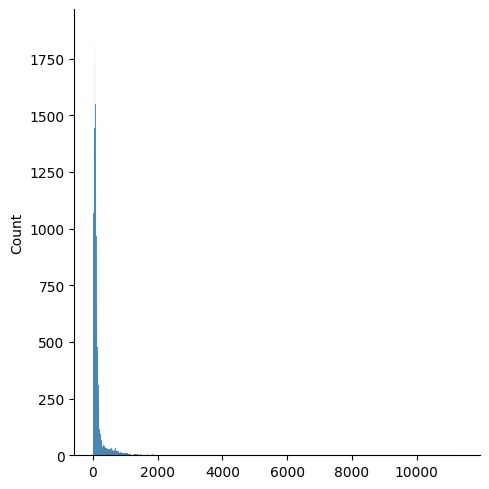

In [32]:
sns.displot(np.array(lengths))

## Extract topics

In [58]:
from bertopic.representation import KeyBERTInspired
from bertopic.representation import PartOfSpeech
from bertopic.representation import MaximalMarginalRelevance
from transformers import pipeline
from bertopic.representation import TextGeneration
# from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer

# vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english", min_df=10)


# main_representation = KeyBERTInspired()
inspired_model = KeyBERTInspired()

# sentence model
# sentence_model = SentenceTransformer("all-mpnet-base-v2")
sentence_model_light = SentenceTransformer("all-MiniLM-L6-v2")

# mmr model
mmr_model = MaximalMarginalRelevance(diversity=0.4)

# pos model
nlp_stanza_pos = spacy_stanza.load_pipeline("en", processors="tokenize, pos")
pos_model = PartOfSpeech(nlp_stanza_pos)

# Create a generator model
prompt = "I have a topic described by the following keywords: [KEYWORDS]. Based on the previous keywords, what is this topic about?"
generator = pipeline('text2text-generation', model='google/flan-t5-base')
generator_model = TextGeneration(generator)

# chain models
chain_model_1 = [inspired_model, mmr_model]
chain_model_2 = [inspired_model, mmr_model, pos_model]
# chain_model_3 = [inspired_model, pos_model, mmr_model]
generator_chain_model_1 = [inspired_model, mmr_model, generator_model]
# generator_chain_model_2 = [inspired_model, mmr_model, pos_model, generator_model]


# Add all models together to be run in a single `fit`
representation_model = {
   "Main": inspired_model,
   # "Pos":  pos_model,
   "Chain: Inspired - MMR":  chain_model_1,
   # "Chain: Inspired - MMR - POS":  chain_model_2,
   # "Chain: Inspired - POS - MMR":  chain_model_3,
   # "Generator": generator_model,
   # "Generator chain: Inspired - MMR": generator_chain_model_1,
   # "Generator chain: Inspired - MMR - POS": generator_chain_model_2
}

2023-09-12 13:40:02 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-09-12 13:40:03 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2023-09-12 13:40:03 WARNING: GPU requested, but is not available!
2023-09-12 13:40:03 INFO: Using device: cpu
2023-09-12 13:40:03 INFO: Loading: tokenize
2023-09-12 13:40:03 INFO: Loading: pos
2023-09-12 13:40:04 INFO: Done loading processors!


1.
* Sentence window: 0
* No join

In [ ]:
topic_model_0, topics_0, probs_0 = topic_extractor.bert_advanced(corpus_window_0_df['processed_text'].to_list(), representation_model=representation_model, embedding_model=sentence_model_light)

Batches:   0%|          | 0/1411 [00:00<?, ?it/s]

In [63]:
topic_model_0_red, topics_0_red, probs_0_red = topic_extractor.bert_advanced(corpus_window_0_df['processed_text'].to_list(), representation_model=representation_model, embedding_model=sentence_model_light, nr_topics=18)

Batches:   0%|          | 0/1411 [00:00<?, ?it/s]

2023-09-12 14:08:20,844 - BERTopic - Transformed documents to Embeddings
2023-09-12 14:08:43,950 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-12 14:13:52,881 - BERTopic - Clustered reduced embeddings
2023-09-12 14:14:42,539 - BERTopic - Reduced number of topics from 415 to 18


In [60]:
topic_model_0.get_topic_info()

,Topic,Count,Name,Representation,Chain: Inspired - MMR,Representative_Docs
0,-1,22245,-1_inflation_demand_growth_economic,"[inflation, demand, growth, economic, revenue,...","[inflation, demand, growth, economic, revenue,...",[predict long term effect war ongoing covid pa...
1,0,852,0_belarus_belarusian_kazakhstan_moldova,"[belarus, belarusian, kazakhstan, moldova, sal...","[belarus, belarusian, kazakhstan, moldova, sal...","[belarus material, belarus market, 2.5 sale be..."
2,1,707,1_energy_renewable_electricity_demand,"[energy, renewable, electricity, demand, megaw...","[energy, renewable, electricity, demand, megaw...",[short term focus clearly energy security end ...
3,2,594,2_logistics_disruption_sourcing_shortage,"[logistics, disruption, sourcing, shortage, in...","[logistics, disruption, sourcing, shortage, in...","[clearly war disruption supply chain, recent p..."
4,3,470,3_europe_eu_european_geopolitical,"[europe, eu, european, geopolitical, asia, ger...","[europe, eu, european, geopolitical, asia, ger...","[course right crisis eastern europe invasion, ..."
...,...,...,...,...,...,...
402,401,10,401_respect_currency_range_strategy,"[respect, currency, range, strategy, understan...","[respect, currency, range, strategy, understan...",[obviously mention answer question respect ran...
403,402,10,402_exposure_gtt_provisioned_impact,"[exposure, gtt, provisioned, impact, update, i...","[exposure, gtt, provisioned, impact, update, i...","[let update gtt exposure project dedicated, le..."
404,403,10,403_year_impact_september_influence,"[year, impact, september, influence, significa...","[year, impact, september, influence, significa...","[yes impact look calibrating year, give specif..."
405,404,10,404_developer_development_engineer_company,"[developer, development, engineer, company, ta...","[developer, development, engineer, company, ta...","[developer base company, additionally strong i..."


In [64]:
topic_model_0_red.get_topic_info()

,Topic,Count,Name,Representation,Chain: Inspired - MMR,Representative_Docs
0,-1,21858,-1_inflation_demand_economic_uncertainty,"[inflation, demand, economic, uncertainty, cri...","[inflation, demand, economic, uncertainty, cri...",[war continue challenging market environment g...
1,0,7385,0_war_inflation_economy_crisis,"[war, inflation, economy, crisis, economic, co...","[war, inflation, economy, crisis, economic, co...",[report challenging year everybody know war co...
2,1,5909,1_impact_million_revenue_billion,"[impact, million, revenue, billion, business, ...","[impact, million, revenue, billion, business, ...",[business overall million million business kin...
3,2,4192,2_coal_gas_oil_export,"[coal, gas, oil, export, fuel, diesel, demand,...","[coal, gas, oil, export, fuel, diesel, demand,...","[oil gas export europe reduce course, gas mark..."
4,3,2018,3_belarus_belarusian_kazakhstan_poland,"[belarus, belarusian, kazakhstan, poland, ukra...","[belarus, belarusian, kazakhstan, poland, ukra...","[talk belarus, obviously operation belarus, bu..."
5,4,1000,4_humanitarian_aid_charity_donation,"[humanitarian, aid, charity, donation, unicef,...","[humanitarian, aid, charity, donation, unicef,...",[addition provide financial support humanitari...
6,5,758,5_slide_presentation_update_move,"[slide, presentation, update, move, activity, ...","[slide, presentation, update, move, activity, ...","[move slide second update, slide update, slide..."
7,6,668,6_think_discuss_speak_discussion,"[think, discuss, speak, discussion, question, ...","[think, discuss, speak, discussion, question, ...","[think come question, question think, talk que..."
8,7,418,7_exposure_visibility_expose_clear,"[exposure, visibility, expose, clear, asset, i...","[exposure, visibility, expose, clear, asset, i...","[exposure, exposure, exposure]"
9,8,388,8_lease_airline_leasing_aircraft,"[lease, airline, leasing, aircraft, airplane, ...","[lease, airline, leasing, aircraft, airplane, ...",[lease rental income drop 1.8 billion impact t...


In [61]:
hierarchical_topics = topic_model_0.hierarchical_topics(corpus_window_0_df['processed_text'].to_list())

100%|██████████| 405/405 [01:19<00:00,  5.06it/s]


Hierarchical clustering

In [62]:
topic_model_0.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

2.
* Sentence window: 0
* Join sentences

In [17]:
topic_model_0_join, topics_0_join, probs_0_join = topic_extractor.bert_advanced(corpus_window_0_join_df['processed_text'].to_list(), representation_model=representation_model, embedding_model=sentence_model_light)

Batches:   0%|          | 0/1226 [00:00<?, ?it/s]

2023-09-04 13:46:31,496 - BERTopic - Transformed documents to Embeddings
2023-09-04 13:46:51,379 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-04 13:51:25,827 - BERTopic - Clustered reduced embeddings
100%|██████████| 359/359 [02:33<00:00,  2.35it/s]


In [20]:
topic_model_0_join.get_topic_info()

,Topic,Count,Name,Representation,Chain: Inspired - MMR,Chain: Inspired - MMR - POS,Generator chain: Inspired - MMR,Representative_Docs
0,-1,20314,-1_inflation_demand_economy_economic,"[inflation, demand, economy, economic, crisis,...","[inflation, demand, economy, economic, crisis,...","[market, war, gas, business, impact, energy, q...","[inflation and market volatility, , , , , , , ...",[mean know war lot uncertainty come especially...
1,0,790,0_belarus_belarusian_kazakhstan_moldova,"[belarus, belarusian, kazakhstan, moldova, cou...","[belarus, belarusian, kazakhstan, moldova, cou...","[belarus, belarusian, revenue, shipment, talen...",[belarusian kazakhstan and moldova are the cou...,"[year go belarus, 2.5 sale belarus, belarus ma..."
2,1,765,1_supplier_supply_logistics_inventory,"[supplier, supply, logistics, inventory, sourc...","[supplier, supply, logistics, inventory, sourc...","[chain, supply, supplier, disruption, inventor...","[sourcing, , , , , , , , , ]","[war war pressure supply chain, clearly war di..."
3,2,371,2_invasion_invade_attack_violence,"[invasion, invade, attack, violence, aggressiv...","[invasion, invade, attack, violence, aggressiv...","[invasion, invade, day, course, start, morning...","[afghanistan invasion, , , , , , , , , ]","[impact situation invasion, invasion, invasion]"
4,3,366,3_coal_demand_market_gas,"[coal, demand, market, gas, pricing, supply, e...","[coal, demand, market, gas, pricing, supply, e...","[coal, thermal, coking, ban, meet, import, ton...","[coal and coking, , , , , , , , , ]",[europe need replace coal volume result price ...
...,...,...,...,...,...,...,...,...
354,353,10,353_healthcare_medical_clinical_hospital,"[healthcare, medical, clinical, hospital, pati...","[healthcare, medical, clinical, hospital, pati...","[patient, clinical, continuity, care, surgery,...",[enrolment in healthcare services for patients...,[healthcare business sector overall clinical s...
355,354,10,354_kiev_ukrainian_relocate_shortage,"[kiev, ukrainian, relocate, shortage, territor...","[kiev, ukrainian, relocate, shortage, territor...","[demographical, ukrainian, bleak, mobilization...","[ukraine ukraine ukraine ukraine ukrain, , , ,...","[actually new new helicopter kiev, kiev, fortu..."
356,355,10,355_stay_leave_continue_long,"[stay, leave, continue, long, say, course, opt...","[stay, leave, continue, long, say, course, opt...","[stay, option, decision, question, course, , ,...",[i want to stay on course if i want to confirm...,"[stay, oh yes yes leave, oh yes yes leave]"
357,356,10,356_capacity_monopoly_limited_production,"[capacity, monopoly, limited, production, euro...","[capacity, monopoly, limited, production, euro...","[capacity, monopoly, cann, malt, optical, outs...","[monopoly of european market, , , , , , , , , ]",[italy get capability produce optical componen...


In [38]:
corpus_window_0_join_df_company = corpus_window_0_join_df.with_columns(pl.Series('topics', topics_0_join)).groupby('id').agg(pl.col('topics','text', 'processed_text')).sort('id')
topics = list(corpus_window_0_join_df_company['topics'])

In [42]:
set_list = []
for i,topic in enumerate(topics):
    set_list.append(list(set(topic)))

In [40]:
set_list

[[82, 20, -1],
 [-1],
 [-1],
 [-1],
 [35, -1],
 [0, -1],
 [45, -1],
 [-1],
 [72, 9, -1],
 [-1],
 [0, 26, -1],
 [-1],
 [193, 6, 7, 8, 11, 12, 13, 114, 275, 117, 215, 122, 157, -1],
 [72, 9, -1],
 [82, -1],
 [78, 85, -1, 41],
 [288, -1, 167],
 [128, 102, 41, 170, 27, 28, -1],
 [32, -1],
 [-1],
 [-1],
 [25, 11, 12, -1],
 [91, 190],
 [-1],
 [96, 20, -1],
 [34, -1],
 [27, 45],
 [-1],
 [46, -1],
 [123, 45, 15],
 [106, -1, 23],
 [24, -1],
 [1, -1],
 [-1],
 [-1],
 [0, 209, 45, -1],
 [312, -1, 151],
 [-1, 63],
 [1, 9, 109, 48, 80, 117, 309, 89, 124, -1],
 [49, 50, 19, 20, -1],
 [291, -1, 30],
 [291],
 [320, 2, 12, 209, -1],
 [-1],
 [2, 167, 40, 41, 143, 343, -1, 63],
 [148, 46],
 [62, 102, 111],
 [90],
 [90],
 [-1],
 [78],
 [102, 236, 148, 343, 26, -1],
 [156, -1],
 [123, 12, -1],
 [152, -1],
 [322, 67, 38, 138, 45, 16, 145, 28, -1],
 [322, 4, 170, 21, 312, -1],
 [-1],
 [298],
 [-1],
 [-1],
 [101, 38, 103, 39, 170, 303, 20, 21, -1],
 [9, 138, 53, -1],
 [9, 11, 21, -1],
 [0, 262, 109, 82, 51, 28

Reduced to 50 topics

In [22]:
topic_model_0_join_50, topics_0_join_50, probs_0_join_50 = topic_extractor.bert_advanced(corpus_window_0_join_df['processed_text'].to_list(), representation_model=representation_model, embedding_model=sentence_model_light, nr_topics=50)

Batches:   0%|          | 0/1226 [00:00<?, ?it/s]

2023-09-04 14:15:38,930 - BERTopic - Transformed documents to Embeddings
2023-09-04 14:15:59,230 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-09-04 14:19:35,767 - BERTopic - Clustered reduced embeddings
100%|██████████| 50/50 [00:28<00:00,  1.78it/s]
2023-09-04 14:37:13,247 - BERTopic - Reduced number of topics from 356 to 50


In [23]:
topic_model_0_join_50.get_topic_info()

,Topic,Count,Name,Representation,Chain: Inspired - MMR,Chain: Inspired - MMR - POS,Generator chain: Inspired - MMR,Representative_Docs
0,-1,20552,-1_impact_economic_demand_effect,"[impact, economic, demand, effect, inflation, ...","[impact, economic, demand, effect, inflation, ...","[war, impact, year, business, market, quarter,...","[economics, , , , , , , , , ]",[ongoing event include covid mitigation effort...
1,0,6643,0_inflation_demand_war_shortage,"[inflation, demand, war, shortage, supply, gas...","[inflation, demand, war, shortage, supply, gas...","[supply, gas, war, chain, inflation, price, ma...","[oil, , , , , , , , , ]",[concerned ongoing global logistics constraint...
2,1,3037,1_earnings_revenue_million_billion,"[earnings, revenue, million, billion, investme...","[earnings, revenue, million, billion, investme...","[business, exposure, eur, impairment, revenue,...","[ebitda, , , , , , , , , ]","[talk net exposure eur million, combination co..."
3,2,1602,2_war_military_conflict_peace,"[war, military, conflict, peace, crisis, invas...","[war, military, conflict, peace, crisis, invas...","[war, conflict, geopolitical, people, uncertai...","[war, conflict, peace, business, , , , , , , ,...","[war, war, war]"
4,3,1402,3_belarus_belarusian_kazakhstan_poland,"[belarus, belarusian, kazakhstan, poland, ukra...","[belarus, belarusian, kazakhstan, poland, ukra...","[ukrainian, business, country, people, belarus...","[belarus, , , , , , , , , ]","[belarus material, year go belarus, belarus]"
5,4,567,4_invasion_invade_attack_war,"[invasion, invade, attack, war, warfare, impac...","[invasion, invade, attack, war, warfare, impac...","[invasion, defense, drone, cyber, invade, atta...","[invasion of iraq, , , , , , , , , ]","[impact invasion business, invasion, year inva..."
6,5,531,5_patient_clinical_trial_hospital,"[patient, clinical, trial, hospital, fda, medi...","[patient, clinical, trial, hospital, fda, medi...","[patient, trial, humanitarian, support, study,...",[fda - a clinical trial of a drug called a ste...,"[look patient patient, development start new c..."
7,6,479,6_export_exporting_exporter_import,"[export, exporting, exporter, import, ship, sh...","[export, exporting, exporter, import, ship, sh...","[export, port, import, shipment, sea, ship, ca...","[import & export of cargo from port, , , , , ,...","[export, export, export]"
8,7,412,7_impact_impacting_effect_damage,"[impact, impacting, effect, damage, hit, invas...","[impact, impacting, effect, damage, hit, invas...","[impact, omicron, quarter, easter, q1, damage,...","[impact of hurricane katrina, , , , , , , , , ]","[impact, ahead pre-covid number summer recover..."
9,8,412,8_employee_colleague_employ_payroll,"[employee, colleague, employ, payroll, office,...","[employee, colleague, employ, payroll, office,...","[employee, colleague, family, safety, people, ...",[employee of a company employing a colleague o...,"[employee, employee business consequence emplo..."


3.
* Sentence window: 3
* Join sentences  

In [21]:
topic_model_3_join, topics_3_join, probs_3_join = topic_extractor.bert_advanced(corpus_window_3_join_df['processed_text'].to_list(), representation_model=representation_model, embedding_model=sentence_model_light)

TypeError: bert_inspired() missing 1 required positional argument: 'representation_model'

In [21]:
topic_model_3_join.get_topic_info().to_csv("topic_model_3_join.csv")

4.
* Sentence window: 5
* Join sentences


In [14]:
topic_model_5_join, topics_5_join, probs_5_join = topic_extractor.bert_inspired(corpus_window_5_join_df['processed_text'].to_list())

Batches:   0%|          | 0/1208 [00:00<?, ?it/s]

2023-08-31 15:06:31,375 - BERTopic - Transformed documents to Embeddings
2023-08-31 15:06:51,024 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-08-31 15:09:00,223 - BERTopic - Clustered reduced embeddings


In [24]:
topic_model_5_join.get_topic_info().to_csv("topic_model_5_join.csv")

5.
* Sentence window: whole paragraph
* Join sentences

In [15]:
topic_model_whole_join, topics_whole_join, probs_whole_join = topic_extractor.bert_inspired(corpus_window_whole_join_df['processed_text'].to_list())

Batches:   0%|          | 0/1215 [00:00<?, ?it/s]

2023-08-31 15:15:23,146 - BERTopic - Transformed documents to Embeddings
2023-08-31 15:15:42,651 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-08-31 15:17:37,673 - BERTopic - Clustered reduced embeddings


In [25]:
topic_model_whole_join.get_topic_info().to_csv("topic_model_whole_join.csv")

38868

In [356]:
probs[1]

array([0.02466603, 0.032443  , 0.0426969 , 0.02744634, 0.02321597,
       0.0192848 , 0.0492035 , 0.01937474, 0.04401463, 0.04043768,
       0.04437236, 0.02610516, 0.02285282, 0.02287447, 0.0305101 ])

In [49]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,19059,-1_inflation_crisis_pandemic_economic,"[inflation, crisis, pandemic, economic, demand...",[market forecast market base current visibilit...
1,0,4650,0_demand_market_business_guidance,"[demand, market, business, guidance, portfolio...",[yes typically provide update midway quarter o...
2,1,820,1_refugee_humanitarian_charity_donation,"[refugee, humanitarian, charity, donation, uni...","[support people refugee, support refugee emplo..."
3,2,660,2_belarus_belarusian_kazakhstan_russian,"[belarus, belarusian, kazakhstan, russian, cou...","[sale belarus, year go belarus, belarus]"
4,3,535,3_wheat_corn_agriculture_agricultural,"[wheat, corn, agriculture, agricultural, grain...","[corn wheat come big way, know difficulty asso..."
...,...,...,...,...,...
301,300,10,300_revenue_growth_year_offset,"[revenue, growth, year, offset, contractual, t...",[emea year year growth quarter negatively affe...
302,301,10,301_freight_turnover_rail_railway,"[freight, turnover, rail, railway, railroad, t...",[look month year freight rail turnover overall...
303,302,10,302_expect_expectation_demand_profitability,"[expect, expectation, demand, profitability, f...",[yes start contract manufacturing know get gen...
304,303,10,303_decline_maintenance_service_growth,"[decline, maintenance, service, growth, offsho...",[service growth america menac strong oil gas o...


In [358]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(corpus_window_0_join_df['processed_text'].to_list(), calculate_tokens=True)

100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


In [359]:
len(topic_distr)

933

In [363]:
topic_distr[1]

array([0.27688306, 0.        , 0.        , 0.        , 0.15484435,
       0.15860631, 0.32902648, 0.        , 0.        , 0.08063981,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [361]:
# topic distribution of a certain document
topic_model.visualize_distribution(topic_distr[1])

In [365]:
# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(corpus_window_0_join_df['processed_text'].to_list()[1], topic_token_distr[1])
df

,conversely,get,europe,north,america,look,geopolitical,risk,particularly,associate,go,look,maybe,derisk,global,basis,move,little,bit,close,headquarters,operation
0_demand_production_industry_market,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.235,0.365,0.365,0.259,0.130,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4_macroeconomic_inflation_inflationary_economy,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.102,0.102,0.204,0.102,0.102,0.102,0.000,0.000,0.000,0.000
5_revenue_business_profit_investment,0.000,0.000,0.000,0.000,0.000,0.000,0.101,0.209,0.209,0.209,0.108,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6_energy_demand_heating_war,0.000,0.115,0.223,0.223,0.223,0.108,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.105,0.211,0.211,0.211,0.106,0.000,0.000
9_grain_foodtech_harvest_soybean,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.106,0.106,0.106,0.000,0.000


In [372]:
# values for individual topics
topic_model.get_topic(1)

[('refinery', 0.48095948),
 ('refiner', 0.4155772),
 ('import', 0.4111076),
 ('oil', 0.3860207),
 ('europe', 0.3736658),
 ('diesel', 0.36351082),
 ('fuel', 0.35027352),
 ('eu', 0.3479474),
 ('supply', 0.34047055),
 ('russian', 0.33826613)]

In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
sentence1 = "Now this slide talks more about the immediate impact where the combination of sanctions and also business destruction in Ukraine leads or may lead to supply chain disruptions."
sentence2 = "We obviously intensively evaluate all the potential impacts, created a task force that meets almost daily to follow on these topics and basically do preventive measures as to limit the potential impact on CEZ."

doc1 = nlp(sentence1)
doc2 = nlp(sentence2)
similarity = doc1.similarity(doc2)

sentences_ = [sentence1, sentence2]
sentence_embeddings = model.encode(sentences_)

print("Cosine Similarity: " + str(util.pytorch_cos_sim(sentence_embeddings[0], sentence_embeddings[1]).item()))
print("similiarity: " + str(similarity))

In [ ]:
# import dill as pickle
# pickle.dump(events_russia, open('../output/pickled/events_russia.pkl', 'wb'))
# pickle.dump(events, open('../output/pickled/events.pkl', 'wb'))

In [ ]:
docs = [event['presentation_collapsed'] + "\n" + event['qa_collapsed'] for event in events_russia]

In [ ]:
df.to_csv('../output/data/overview.csv', index=False)

In [ ]:
#  df[['company', 'ticker', 'ticker_new', 'date', 'russia', 'russia_count', 'sanction_count']].to_csv('../output/data/overview_jakob.csv', index=False)
# with open('../output/data/overview_jakob.csv', 'rb') as f_in:
#     with gzip.open('../output/data/overview_jakob.csv.gz', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

Create 15 samples for each category: russia and election and save it in the
corresponding directory.

In [ ]:
if len(df[df['russia'] == 'russia & sanctions']) >0:sample_files_russia = df[df['russia'] == 'russia'].sample(8)['file'].tolist() + df[df['russia'] == 'russia & sanctions'].sample(7)['file'].tolist()
if len(df[df['election'] == 'presidential election']) >0: sample_files_election = df[df['election'] == 'presidential election'].sample(15)['file'].tolist()

In [ ]:
# delete all files in folder
if 'sample_files_russia' in locals() or 'sample_files_russia' in globals():
    folder = '../output/sample transcripts/russia/'
    files = os.listdir(folder)
    for f in files:
        os.remove(folder + f)
    # copy sample files to folder
    for file in sample_files_russia:
        shutil.copy(file, folder)

In [ ]:
# delete all files in folder
if 'sample_files_election' in locals() or sample_files_election in globals():
    folder = '../output/sample transcripts/election/'
    files = os.listdir(folder)
    for f in files:
        os.remove(folder + f)
    # copy sample files to folder
    for file in sample_files_election:
        shutil.copy(file, folder)

Polars

In [ ]:
keys_to_keep = ['file', 'body_orig']

In [ ]:
events_new_trimmed = [{key: event[key] for key in keys_to_keep} for event in events_new]

In [ ]:
eventsDF = pl.from_dicts(events_new_trimmed)

In [ ]:
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(E|e)lections').alias("elections_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(S|s)anctions').alias("sanctions_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(R|r)ussia').alias("russia_count"))

In [ ]:
len(eventsDF.filter(pl.col("elections_count") > 0))

In [ ]:
len(eventsDF.filter((pl.col("sanctions_count") > 0) & (pl.col("russia_count") > 0)))